# The Deustch-Jozsa Algorithm

This notebook is  based on [this](https://www.ryanlarose.com/uploads/1/1/5/8/115879647/quic09-dj-algorithm.pdf) and [this](https://quantum-computing.ibm.com/support/guides/quantum-algorithms-with-qiskit?page=5cbaeb3b74a4010049e1a2a3#) set of notes, which was written by Ryan LaRose and IBM.
$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$

Here’s the problem we want to solve:

---

*Definition* (The Deustch-Jozsa Problem). Let $f : \{0, 1\} \to \{0, 1\}$. Does $f(0) = f(1)$?
 
---

This is often stated in a different way: “Is $f$ constant or balanced? By constant, we mean $f(0) = f(1)$, and by balanced we mean $f(0) \neq f(1)$.

How many classical queries does it take to solve this problem? That’s a pretty easy exercise. It’s two. It must be two since the values of $f(0)$ and $f(1)$ are completely independent of each other. We have to ask what both values are, then compare to see if they’re the same or different.

How many quantum phase queries does it take to solve this problem? If we want to expect a quantum speedup, we should probably say one! (“It’s got to be an integer, it’s less than two, can’t be zero...”) Interestingly, unlike the classical algorithm, we don’t learn explicitly what either of the values $f(0)$ or $f(1)$ are, we only learn if $f(0) = f(1)$ or not. (Equivalently, the parity.)

**Solving the Problem**

Now for the interesting part: the quantum algorithm that solves the DJ problem! Here is the DJ algorithm written in the quantum circuit model ($Q_f$ is a phase query):
<img src="fig1.png" align="middle">

How does this work? Let’s work through the math, which only takes a few lines. We’ll omit normalization coefficents throughout.

$$\ket{0} \mapsto $$

(first Hadamard)
$$ \mapsto \ket{0} + \ket{1}$$

(phase query)
$$ \mapsto (-1)^{f(0)} \ket{0} + (-1)^{f(1)} \ket{1}$$

(second Hadamard)
$$\mapsto (-1)^{f(0)} \Big ( \ket{0} + \ket{1} \Big ) + (-1)^{f(1)} \Big ( \ket{0} - \ket{1} \Big ) = \ket{\psi}$$

How does this solve our problem? Consider the case where $f(0) = f(1)$. Then, the coefficient of the $\ket{1}$ state goes to zero and the coefficient of the $\ket{0}$ state becomes 1 (when properly normalized). If $f(0) \neq f(1)$, the opposite happens, and the resulting state is $\ket{1}$. Thus, if we measure 0, we know the state must have been $\ket{0}$, meaning that $f(0) = f(1)$. If we measure 1, we know the state must have been $\ket{1}$, meaning that $f(0) \neq f(1)$. Thats it! One query. 

What’s the key thing happening in the DJ algorithm that allows us to solve the problem in only one query? It’s **interference**, both **constructive** and **destructive** interference. (Of course superposition is at play here too, since interference depends on superposition.) In both cases, the state encoding the answer gets constructive interference and the state with the wrong answer gets destructive interference. This is at the heart of all (good) quantum algorithms. The difficulty is how to choreograph such an interference pattern when *you don’t know what the answer is a priori*. That is, you don’t know what states should get constructive interference and which states should get destructive interference.

---

*Example*: Simulating the DJ Algorithm with light.

<img src="fig3.png" align="middle">
This figure shows how one could implement the DJ algorithm using light and standard optical equipment. A beam of light is sent through a beam splitter and into the “black box,” which could be realized by a person who knows the function values, just as the oracle does, and implements $\pi$ phase shifters appropriately on each beam. Specifically, if $f(0) = 1$, shift the phase of the top beam, else do nothing. Similarly for the bottom beam with $f(1)$. We then reflect both beams using mirrors to combine them at the detector (note: Hadmard is self-inverse. What’s the inverse of a beam splitter? A mirror!). If we measure any light, we know there must be constructive interference between the two paths, hence the function is constant. If we measure no light, there must be destructive interference, telling us the function is balanced.

Note that this is really a classical simulation of the DJ algorithm, since we’re not really using any quantum phenomena of the light here. It’s just a classical beam. If we wanted to make it quantum, we could restrict to a single photon from the photon source.
 
---

## Qiskit Implementation

In real implementation of DJ algorithm two qubits is used, and one is used as an ancilla qubit (note: an ancilla qubit is an additional qubit that is used in the quantum computation). In this way, the query function $Q_f$ was realized. Let us see how it works.
<img src="fig2.png" align="middle">

1. The first qubit is initialized to $\ket{0}$ and second is initialized to $\ket{1}$
$$\ket{\psi}_1 = \ket{0}\ket{1}_a$$

2. Apply Hadamard on both qubits:
$$\ket{\psi_2} = \Big ( \ket{0} + \ket{1} \Big ) \Big ( \ket{0}_a - \ket{1}_a \Big ) = \ket{0}\ket{0}_a - \ket{0} \ket{1}_a + \ket{1} \ket{0}_a - \ket{1} \ket{1}_a$$

3. The query function $Q_f$ can be implemented in different ways. Let us consider the case where $f(0) = 0$ and $f(1) = 1$, thus $Q_f = CX_{12}$:
$$\ket{\psi_3} = \ket{0}\ket{0}_a - \ket{0} \ket{1}_a + \ket{1} \ket{1}_a - \ket{1} \ket{0}_a = \Big ( \ket{0} - \ket{1} \Big ) \Big ( \ket{0}_a - \ket{1}_a \Big )$$

4. Apply Hadamard on both qubits again:
$$\ket{\psi_4} = \ket{1} \ket{1}_a$$
In general we can write output state as $\ket{\psi_4} = \pm \ket{f(0) \oplus f(1)} \ket{1}_a$. Here we extracted *global* information about function $f(x)$ from our quntum cirquit with only one query.

5. Measuring the first qubit will give 1; therefore, $f(0) \neq f(1)$

We now implement the Deutsch-Jozsa algorithm with Qiskit by first preparing the environment.

In [1]:
#initialization
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random

# importing Qiskit
from qiskit import IBMQ, BasicAer
#from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

# import basic plot tools
from qiskit.tools.visualization import plot_histogram

Next, we define the quantum circuit.

Secret function:
f(x) = <1, 1>


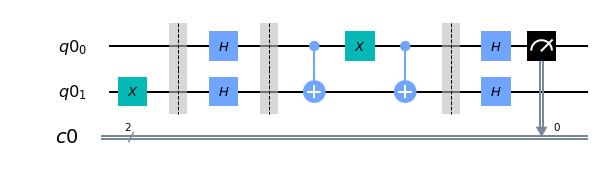

In [2]:
# Creating registers
qr = QuantumRegister(2)
# classical registers for recording the measurement on qr
cr = ClassicalRegister(2)

deujosCircuit = QuantumCircuit(qr, cr)
barriers = True

# initialize the ancilla qubit in the |1> state
deujosCircuit.x(qr[1])

# Apply barrier 
if barriers:
    deujosCircuit.barrier()

# Apply Hadamard gates before querying the oracle
deujosCircuit.h(qr[0])    
deujosCircuit.h(qr[1])    

# Apply barrier 
if barriers:
    deujosCircuit.barrier()

# Query the oracle
def make_oracle(secret_function):
    """ Gates implementing the secret function f(x)."""
    if secret_function[0]:
        [deujosCircuit.cx(qr[0], qr[1]), deujosCircuit.x(qr[0])]

    if secret_function[1]:
        deujosCircuit.cx(qr[0], qr[1])
    
secret_function = [random.randint(0,1) for _ in range(2)]
print('Secret function:\nf(x) = <{}>'.format(', '.join(str(e) for e in secret_function)))

make_oracle(secret_function)

# Apply barrier 
if barriers:
    deujosCircuit.barrier()

# Apply Hadamard gates after querying the oracle
deujosCircuit.h(qr[0])    
deujosCircuit.h(qr[1])    

# Measure the input qubit
deujosCircuit.measure(qr[0], cr[0])

# we can draw the cirquit
deujosCircuit.draw(output="mpl")

Result of f(0)⊕f(1):
0 (1024 shots)


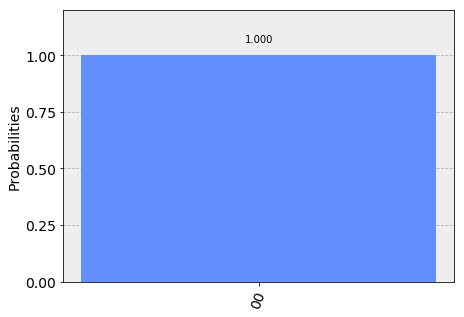

In [3]:
# use local simulator
backend = BasicAer.get_backend('qasm_simulator')
shots = 1024
results = execute(deujosCircuit, backend=backend, shots=shots).result()
answer = results.get_counts()

# categorize answers to c0 = 0 and c0 = 1
answer_c0 = {}
print('Result of f(0)⊕f(1):')
for c1c0 in answer:
    print('{} ({} shots)'.format(c1c0[1], answer[c1c0]))

plot_histogram(answer)